In [ ]:
#link to the full dataset image: http://maps.actualscience.net/MITgcm_llc_maps/llc_4320/

# TODO #1
# -make some plots of data (e.g. W, theta, etc.)
# -in latitude vs depth (at a particular longitude, e.g. 0)

# -make some maps of *depth-averaged* quantities
# -makes some plots of *zonally-averaged* quantities (avg in longitude)




$\alpha$

In [ ]:
# TODO #2
# - Clean up the notebook! delete non-useful cells, make it flow linearly, add commentary
# - make weighted horizontal means
# - make weighted depth mean
# - make weighted global mean of T and S
# - ...then do this all as timeseries
# - install xrft: https://github.com/rabernat/xrft



In [ ]:
#Questions and Answers, logged as they arise

#1) what's up with the 0 values in the depth plots? 
   #Is this the ocean floor? Is there a way to mask this if so?
    
    #Answer: Yes it's the sea floor. You can mask this by
    #create the dataarray with .where(ds.hFacC>0)
    #instead of .where(ds.hFacC[0]>0)


#2) what's up with the indexing mess ^^?
    # A problem arises when you create a dataarray as 
    # ds.Variable[...].where(ds.hFacC[0]>0) because
    # .where() broadcasts the dataarray onto the dimensions of 
    # the masking array. Better to call masked then slice
        
    
#3) Am I right in suspecting that DataSet.Variable takes much longer to plot than DataSet.Variable.load()? Why is this?

    #.load() stores the dataset in memory. It *is* faster but 
    #one must pay attention to the size of the dataset
    #and available memory

#4) Why doesn't depth averaging with drF work?
    # drF measures distance between cell faces, but Z is flux across those faces
    # so drF isn't well-defined at the values of Z
    # use ds.drC instead
    
    #NOTE ^^ this still doesn't quite work; 
    # w has dimension 'Zl' and drC has 'Zpl'


In [1]:
#import libraries and stuff

import xarray as xr
import numpy as np
# import xmitgcm
from matplotlib import pyplot as plt
import os
from glob import glob
%matplotlib inline
import xmitgcm
import dask


In [2]:
#identify desired dataset path

ddir = '/swot/SUM01/LLC/llc_4320_agulhas/'
all_files = glob(os.path.join(ddir, 'llc_4320_agulhas.0*.nc'))
all_files = sorted(all_files)
#print(len(all_files))
#all_files[-1]

In [3]:
#create dataset
ds = xr.open_mfdataset(all_files[:10], decode_cf=False, autoclose=True)
ds = ds.set_coords(['iter', 'face'])
grid = xr.open_dataset(ddir + 'llc_4320_agulhas_grid.nc').chunk()
ds = xr.merge([grid, ds])
ds = xmitgcm.mds_store._swap_dimensions(ds, geometry='sphericalpolar')

In [ ]:
#For reference
#ds
#ds.info()

#ds.hFacC

In [6]:
#create desired dataarrays; these need to be
#narrowed down; include zero time are masked to 
#only show water

#create the masking
#mask_c = (ds.hFacC>0)

#create dataarrays for salt, potential t, and w at zeroeth time step
#using masking created above

#salt_masked = ds.Salt[0].where(mask_c).load()
#w_masked = ds.W[0].where(mask_c).load()
#T_masked = ds.Theta[0].where(mask_c).load()


#I tried multiple masking methods to see how comparatively long things take 

#salt_masked = ds.Salt[0].where(ds.hFacC>0).load()
#w_masked = ds.W[0].where(ds.hFacC>0).load()
#T_masked = ds.Theta[0].where(ds.hFacC>0).load()


#It seems like calling .where(ds.hFacC[0]>0) is *way* faster
#than calling .where(ds.hFacC>0); probably because it has to check fewer dimensions

salt_masked = ds.Salt[0].where(ds.hFacC[0]>0).load()
w_masked = ds.W[0].where(ds.hFacC[0]>0).load()
T_masked = ds.Theta[0].where(ds.hFacC[0]>0).load()


#I'm calling these as dictionaries; this allows me to 
#create time series.

#salt_masked = dict()
#T_masked = dict()

#for t in range (0, 4):
#    salt_masked[t] = ds.Salt[t].where(ds.hFacC[0]>0).load()

#for t in range(0, 4):
#    T_masked[t] = ds.Theta[t].where(ds.hFacC[0]>0).load()




In [ ]:
#demonstrate the use of .sel()
#use to specify which portion of dataarray 
#is desired, called by dim values, specify
#method='nearest' if exact value isn't known
#slicing and 'nearest' cannot be called together,
#call .sel() or .isel() twice to use both

#salt0.sel(Z=0, method='nearest').plot()
#salt0 = salt_masked[0].isel(time=0).load()
#salt0.sel(XC=0, method='nearest').plot()
#salt0.sel(XC=0, method='nearest').sel(Z=slice(0,-2000)).plot.contourf()

# The following plots are not averaged

In [15]:
#W depth vs Lat, Theta depth vs lat, sss lat vs depth, at longitutde 0

w_long_0 = w_masked.sel(XC = 0, method = 'nearest')

T_long_0=dict()
for t in range(0,4):
    T_long_0[t] = T_masked[t].sel(XC = 0, method = 'nearest')

#salt_long_0 = dict()   
#for t in range(0,4):
#    salt_long_0[t] = salt_masked[t].sel(XC = 0, method = 'nearest')

In [ ]:
w_long_0.plot()

In [21]:
T_long_0_2 = T_long_0[1]-T_long_0[0]
T_long_0_3 = T_long_0[2]-T_long_0[1]
T_long_0_4 = T_long_0[3]-T_long_0[2]

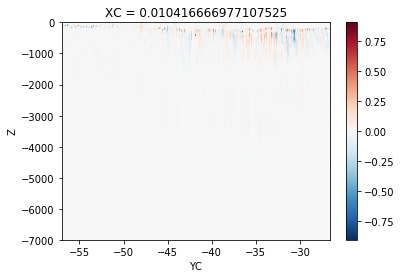

In [23]:
T_long_0_2.plot()

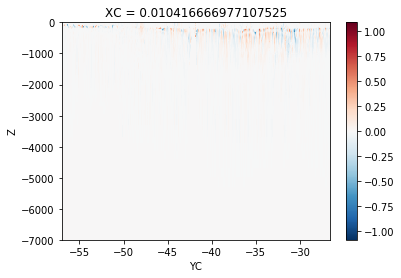

In [24]:
T_long_0_3.plot()

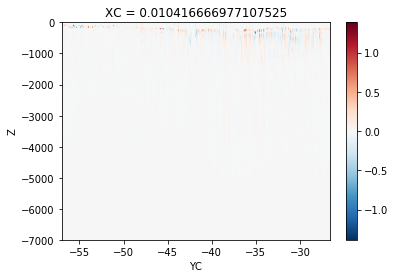

In [25]:
T_long_0_4.plot()

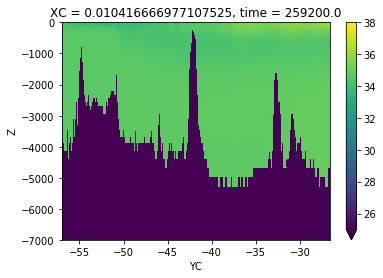

In [13]:
salt_long_0[0].plot(vmin = 25, vmax = 38)


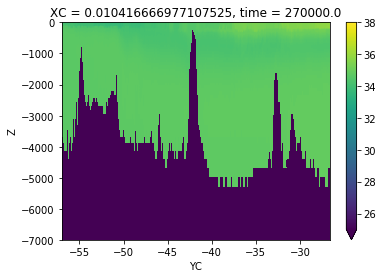

In [12]:
salt_long_0[3].plot(vmin = 25, vmax = 38)

# The following plots are averaged but not
# weighted by cell dimension

In [ ]:
#depth average, lat v. long

w_depth_average = w_masked.mean(dim = 'Zl')
T_depth_average = T_masked.mean(dim = 'Z')
salt_depth_average = salt_masked.mean(dim = 'Z')



In [ ]:
#zonal averages, depth vs. longitude

salt_zonal_average = salt_masked.mean(dim = 'YC')
T_zonal_average = T_masked.mean(dim = 'YC')
w_zonal_average = w_masked.mean(dim = 'YC')

In [ ]:
salt_depth_average.plot()

In [ ]:
T_depth_average.plot()


In [ ]:
w_depth_average.plot(vmin = -.01, vmax = .01)

# Here begin the weighted average plots

In [4]:
depth = ds.drF.load()
area = ds.rA.load()
depth_w = ds.drC.load()

In [7]:
#Create depth weightings for T


T_depth = T_masked*depth
T_depth_weighted_mean = T_depth.sum(dim = 'Z')/(depth.sum())

# w has no Z dimension, so depth averaging is tricky. What to do here?

In [ ]:
#Create depth weightings for W


#w_depth = w_masked*depth_w
#w_depth_weighted_mean = w_depth.sum(dim = 'Zl')/(depth_w.sum())

In [8]:
#Create depth weightings for Salt

salt_depth = salt_masked*depth
salt_depth_weighted_mean = salt_depth.sum(dim = 'Z')/(depth.sum())

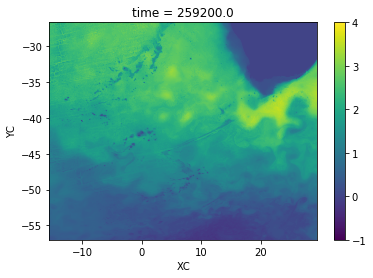

In [9]:
T_depth_weighted_mean.plot(vmin = -1, vmax= 4)

In [ ]:
plt.close()

In [ ]:
#Still figuring out how to depth weight w

#w_depth_weighted_mean.plot()

In [ ]:
plt.close()

In [ ]:
salt_depth_weighted_mean.plot()


In [ ]:
plt.close()

In [ ]:
T_horizontal_weighted = T_masked*ds.rA
T_horizontal_weighted_mean = T_horizontal_weighted.sum(dim = 'XC').sum(dim = 'YC')/ds.rA.sum()
T_horizontal_weighted_mean

In [ ]:
w_horizontal_weighted = w_masked*ds.rA
w_horizontal_weighted_mean = w_horizontal_weighted.sum(dim = 'XC').sum(dim = 'YC')/ds.rA.sum()
w_horizontal_weighted_mean

In [ ]:
salt_horizontal_weighted = salt_masked*ds.rA
salt_horizontal_weighted_mean = salt_horizontal_weighted.sum(dim = 'XC').sum(dim = 'YC')/ds.rA.sum()
salt_horizontal_weighted_mean

In [ ]:
T_horizontal_weighted_mean.plot()

In [ ]:
w_horizontal_weighted_mean.plot()

In [ ]:
salt_horizontal_weighted_mean.plot()

## Global Averages ##


In [ ]:
salt_globally_weighted = salt_masked*depth*area
salt_globally_average = salt_globally_weighted.sum(dim = 'XC').sum(dim = 'YC').sum(dim = 'Z')/(depth.sum()*area.sum())

In [ ]:
T_globally_weighted = T_masked*depth*area
T_globally_average = T_globally_weighted.sum(dim = 'XC').sum(dim = 'YC').sum(dim = 'Z')/(depth.sum()*area.sum())

In [ ]:
salt_globally_average

In [ ]:
T_globally_average

In [ ]:
print (ds.drF)
print (ds.rA)

In [ ]:
ds.time

In [ ]:
#Ryan's demonstration of gridding variables
#Reference these to do weighted averages

ds.rA
ds.rA.plot()
volume_c = (ds.rA * ds.hFacC * ds.drF).load()
volume_c.sum()

In [ ]:
print(volume_c)